# EDA, modeling and package testing

1. [EDA](#eda)
   - [Check duplicated data](#1-check-duplicated-data)
   - [Get `X` and `y` and split the dataset](#2-get-x-and-y-and-split-the-dataset)
   - [EDA with `X_train`](#3-eda-with-x_train)
     - [Step1: Missing value](#step1-missing-value)
     - [Step2: Feature distribution](#step2-feature-distribution)
     - [Step3: Check strong co-linearity](#step3-check-strong-co-linearity)
     - [Step4: Histogram](#step4-histogram)
2. [Build model with pipeline](#build-model-with-pipeline)
   - [Check the training data](#1-check-the-training-data)
   - [Build pipeline](#2-build-pipeline)
     - [Step1: Logarithm pipeline](#step1-logarithm-pipeline)
     - [Step2: Assemble pipeline](#step2-assemble-pipeline)
   - [Modeling](#3-modeling)
     - [Step1: Transform data](#step1-transform-data)
     - [Step2: Common way](#step2-common-way)
     - [Step3: Build model pipeline](#step3-build-model-pipeline)
3. [Package](#package)
4. [InterpreStability](#interprestability)
   - [Train sub-models](#1-train-sub-models)
   - [Calculate correlation matrix](#2-calculate-correlation-matrix)
   - [Visualization](#3-visualization) 

# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

from sklearn.metrics import roc_curve, auc, roc_auc_score


In [2]:
# Read the dataset

df = pd.read_excel("default of credit card clients.xls")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [3]:
# Rename columns

df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## 1. Check duplicated data

In [4]:
df.duplicated().sum()

0

## 2. Get `X` and `y` and split the dataset

In [5]:
dataset = df.copy()
dataset

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [6]:
X = dataset.drop(['ID', 'default payment next month'], axis=1)
y = dataset['default payment next month']

X.shape, y.shape

((30000, 23), (30000,))

In [7]:
# trainval : test = 8 : 2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                            test_size=0.2, stratify=y, random_state=42)  # 0.2 1

# train : val = 7 : 1
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                  test_size=1/8, stratify=y_train_val, random_state=42)  # 1/8  2

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (21000, 23)
Validation: (3000, 23)
Test: (6000, 23)


In [8]:
y_train.value_counts()

default payment next month
0    16355
1     4645
Name: count, dtype: int64

## 3. EDA with `X_train`

### Step1: Missing value

In [9]:
X_train.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

### Step2: Feature distribution

In [10]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000
mean,167037.428571,1.606762,1.853048,1.555238,35.426095,-0.015238,-0.136905,-0.167238,-0.222476,-0.270381,...,46448.135333,42852.895190,39914.616476,38407.733476,5611.608667,5.836023e+03,5274.841333,4777.251238,4787.528048,5237.643143
std,129182.316837,0.488481,0.794599,0.521454,9.204026,1.117701,1.195484,1.195071,1.164269,1.127789,...,67944.711379,63835.115387,60469.917159,58946.267592,16371.446817,1.963075e+04,18155.107317,14988.330451,15159.715098,18065.906826
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-61506.000000,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2551.750000,2284.250000,1715.000000,1202.750000,1000.000000,8.167500e+02,390.000000,291.750000,241.000000,100.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19875.000000,18889.500000,18013.500000,16892.000000,2100.000000,2.012000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59565.750000,53953.500000,50024.250000,48828.750000,5006.000000,5.000000e+03,4537.750000,4003.500000,4031.500000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,693131.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.215471e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [11]:
X_train.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_1        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
dtype: object

In [12]:
for col in X_train.columns:
    print(X_train[col].value_counts())
    print()

LIMIT_BAL
50000     2370
20000     1382
30000     1105
200000    1103
80000     1098
          ... 
690000       1
660000       1
16000        1
800000       1
780000       1
Name: count, Length: 79, dtype: int64

SEX
2    12742
1     8258
Name: count, dtype: int64

EDUCATION
2    9805
1    7430
3    3426
5     204
4      84
6      40
0      11
Name: count, dtype: int64

MARRIAGE
2    11241
1     9497
3      227
0       35
Name: count, dtype: int64

AGE
29    1133
27    1044
28     986
30     984
26     873
31     873
32     854
25     843
34     826
33     794
35     794
24     785
36     768
37     715
38     663
23     651
39     641
40     594
41     557
42     550
43     474
44     472
45     447
22     397
46     375
47     352
49     330
48     303
50     299
53     233
51     231
52     216
54     165
55     144
56     131
57      86
58      83
59      58
21      46
60      43
61      37
62      32
63      23
66      20
64      18
65      15
69      14
67      10
70       7
73 

In [13]:
# Change labels 0,5,6 to 4 which represent other category
X_train['EDUCATION'] = X_train['EDUCATION'].apply(lambda x: 4 if x in [0, 5, 6] else x)

# Replace 0 to 3
X_train['MARRIAGE'] = X_train['MARRIAGE'].replace(0, 3)

# Replace -2, -1 to -1
def replace_to_neg(col):
    fil = (X_train[col] == -2) | (X_train[col] == -1)
    X_train.loc[fil, col] = -1

for i in ['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    replace_to_neg(i)

In [14]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000
mean,167037.428571,1.606762,1.841619,1.560238,35.426095,0.074952,-0.011857,-0.031952,-0.078571,-0.118667,...,46448.135333,42852.895190,39914.616476,38407.733476,5611.608667,5.836023e+03,5274.841333,4777.251238,4787.528048,5237.643143
std,129182.316837,0.488481,0.745966,0.520900,9.204026,0.986552,1.035676,1.024337,0.983418,0.935826,...,67944.711379,63835.115387,60469.917159,58946.267592,16371.446817,1.963075e+04,18155.107317,14988.330451,15159.715098,18065.906826
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-61506.000000,-81334.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2551.750000,2284.250000,1715.000000,1202.750000,1000.000000,8.167500e+02,390.000000,291.750000,241.000000,100.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19875.000000,18889.500000,18013.500000,16892.000000,2100.000000,2.012000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59565.750000,53953.500000,50024.250000,48828.750000,5006.000000,5.000000e+03,4537.750000,4003.500000,4031.500000,4000.000000
max,1000000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,693131.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.215471e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [9]:
num_features = X_train.select_dtypes(include=['int64']).columns.tolist()
num_features

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

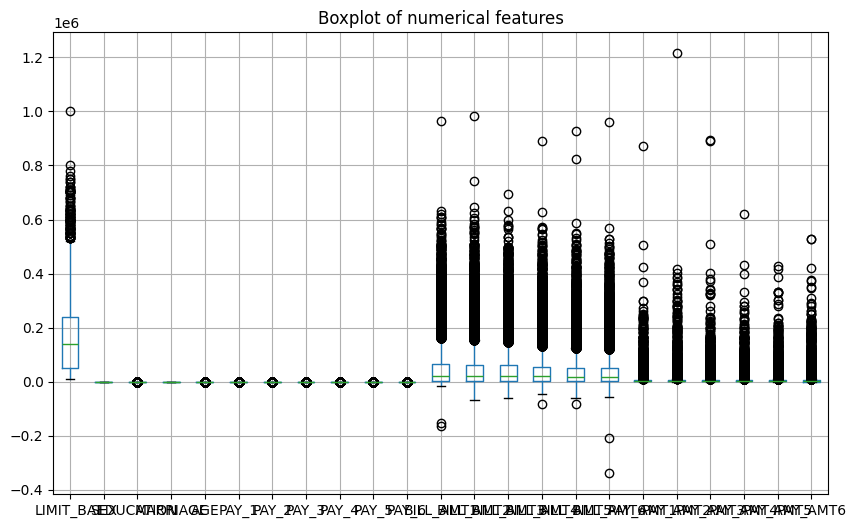

In [16]:
plt.figure(figsize=(10, 6))
X_train.boxplot()
plt.title('Boxplot of numerical features')
plt.show()

### Step3: Check strong co-linearity

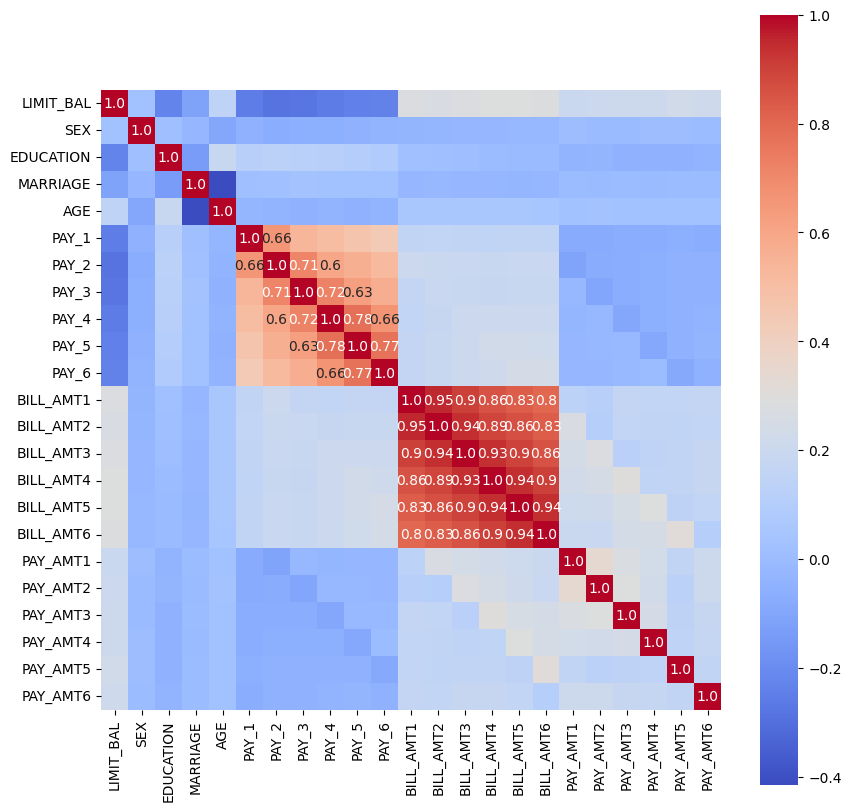

In [17]:
plt.figure(figsize=(10, 10))

corr = X_train.corr()

mask = np.abs(corr) >= 0.6
annot = np.where(mask, corr.round(2).astype(str), np.full(corr.shape, ""))

sns.heatmap(corr, cmap='coolwarm', square=True, annot=annot, fmt='');

In [11]:
features = [feature for feature in num_features
                if feature not in ['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5']]
features

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_6',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

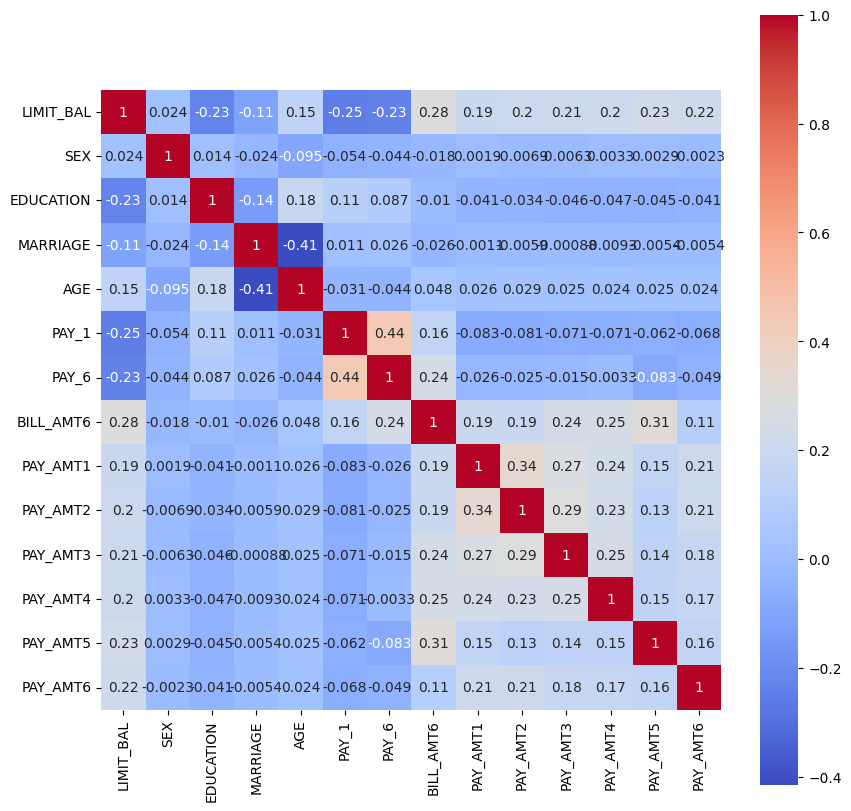

In [19]:
plt.figure(figsize=(10, 10))

corr_2 = X_train[features].corr()
sns.heatmap(corr_2, cmap='coolwarm', square=True, annot=True);

### Step4: Histogram

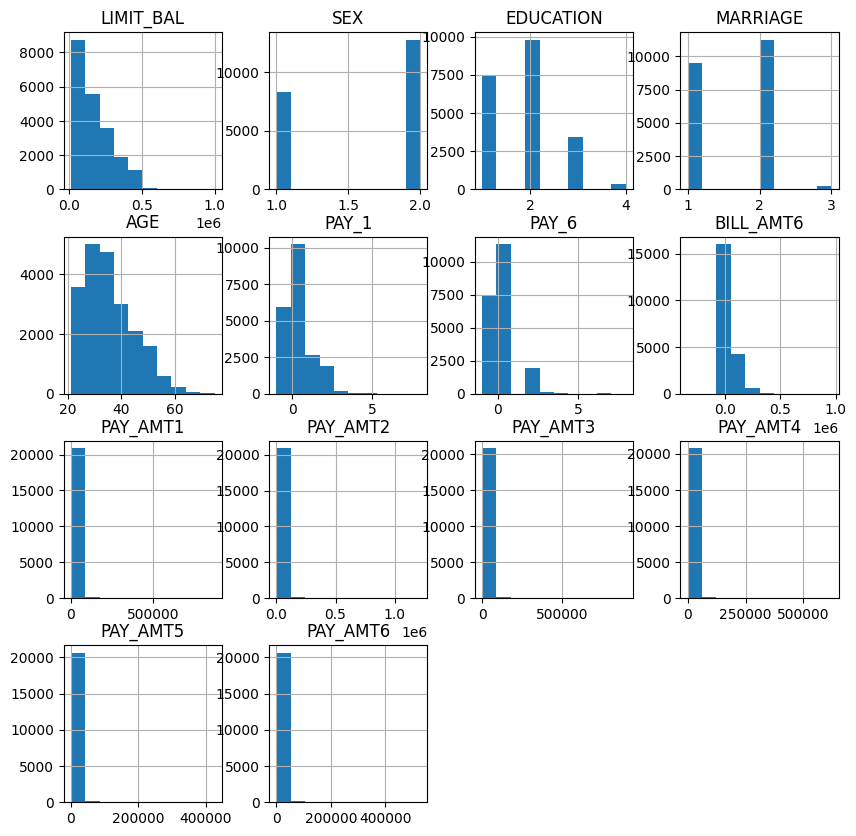

In [20]:
X_train[features].hist(figsize=(10, 10));

/Users/shiyunwa/anaconda3/envs/deeplearning/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


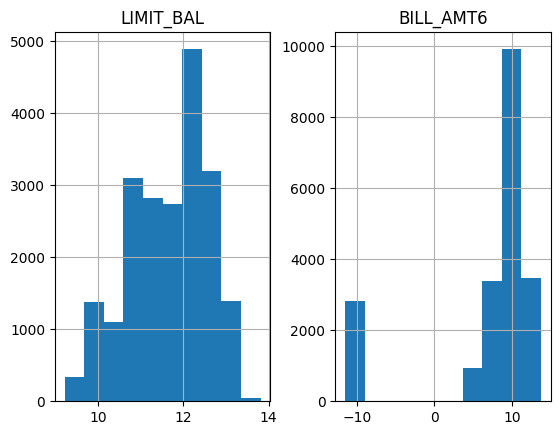

In [21]:
np.log(X_train[['LIMIT_BAL', 'BILL_AMT6']] + 1e-5).hist();

In [12]:
to_log = ['LIMIT_BAL']
no_log = [feature for feature in features if feature not in to_log]
no_log

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_6',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

# Build model with pipeline

## 1. Check the training data

In [23]:
X_train[features].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_6,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000
mean,167037.428571,1.606762,1.841619,1.560238,35.426095,0.074952,-0.127571,38407.733476,5611.608667,5.836023e+03,5274.841333,4777.251238,4787.528048,5237.643143
std,129182.316837,0.488481,0.745966,0.520900,9.204026,0.986552,0.948536,58946.267592,16371.446817,1.963075e+04,18155.107317,14988.330451,15159.715098,18065.906826
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-1.000000,-1.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,1202.750000,1000.000000,8.167500e+02,390.000000,291.750000,241.000000,100.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,16892.000000,2100.000000,2.012000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,48828.750000,5006.000000,5.000000e+03,4537.750000,4003.500000,4031.500000,4000.000000
max,1000000.000000,2.000000,4.000000,3.000000,75.000000,8.000000,8.000000,961664.000000,873552.000000,1.215471e+06,896040.000000,621000.000000,426529.000000,528666.000000


## 2. Build pipeline

### Step1: Logarithm pipeline

In [13]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, seed=1e-5):
        self.seed = seed

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        return np.log(X + self.seed)

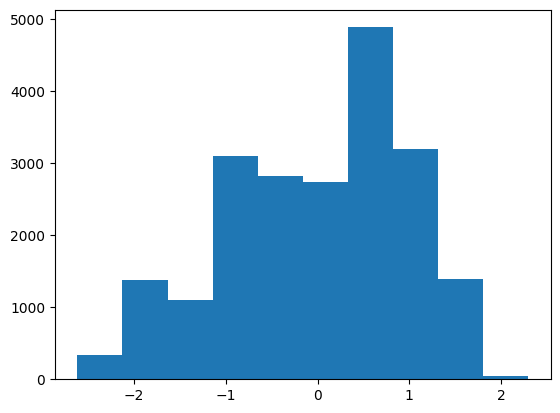

In [14]:
log_pipeline = make_pipeline(SimpleImputer(), LogTransformer(), StandardScaler())
plt.hist(log_pipeline.fit_transform(X_train[to_log]));

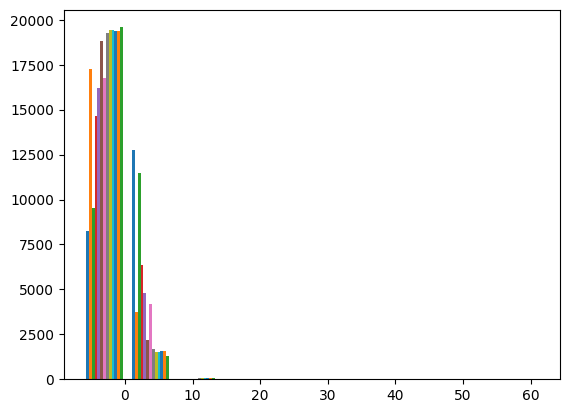

In [15]:
num_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
plt.hist(num_pipeline.fit_transform(X_train[no_log]));

### Step2: Assemble pipeline

In [16]:
final_pipeline = ColumnTransformer([('log_num', log_pipeline, to_log),
                                   ('num', num_pipeline, no_log)])
final_pipeline

ColumnTransformer(transformers=[('log_num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('logtransformer',
                                                  LogTransformer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['LIMIT_BAL']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                                  'PAY_1', 'PAY_6', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6'])])

## 3. Modeling

### Step1: Transform data

In [17]:
X_train_prepared = final_pipeline.fit_transform(X_train)
X_val_prepared = final_pipeline.transform(X_val)
X_test_prepared = final_pipeline.transform(X_test)

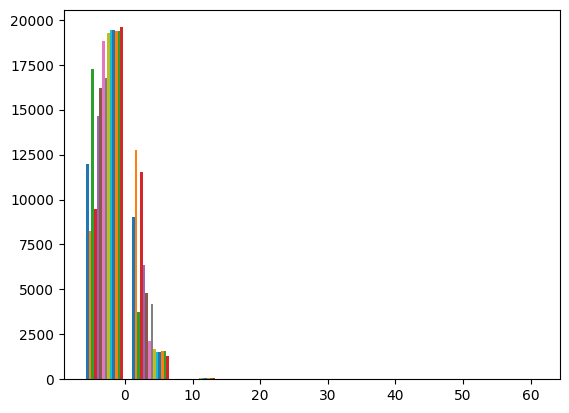

In [29]:
plt.hist(X_train_prepared);

### Step2: Common way

epoch 0  | loss: 3.91685 | val_0_unsup_loss_numpy: 1.6195600032806396|  0:00:01s
epoch 10 | loss: 0.96467 | val_0_unsup_loss_numpy: 0.933139979839325|  0:00:18s
epoch 20 | loss: 0.91679 | val_0_unsup_loss_numpy: 0.8702899813652039|  0:00:35s
epoch 30 | loss: 0.88668 | val_0_unsup_loss_numpy: 0.8205900192260742|  0:00:50s
epoch 40 | loss: 0.86357 | val_0_unsup_loss_numpy: 0.7851200103759766|  0:01:07s
epoch 50 | loss: 0.8872  | val_0_unsup_loss_numpy: 0.7336999773979187|  0:01:23s
epoch 60 | loss: 0.88126 | val_0_unsup_loss_numpy: 0.7223700284957886|  0:01:38s
epoch 70 | loss: 0.86395 | val_0_unsup_loss_numpy: 0.7088099718093872|  0:01:54s
epoch 80 | loss: 0.82392 | val_0_unsup_loss_numpy: 0.6991099715232849|  0:02:09s
epoch 90 | loss: 0.85092 | val_0_unsup_loss_numpy: 0.7028899788856506|  0:02:23s
Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_val_0_unsup_loss_numpy = 0.6763700246810913


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.48098 | val_0_auc: 0.73246 |  0:00:07s
epoch 10 | loss: 0.43914 | val_0_auc: 0.76212 |  0:01:09s
epoch 20 | loss: 0.43676 | val_0_auc: 0.76225 |  0:02:11s
epoch 30 | loss: 0.43703 | val_0_auc: 0.7625  |  0:03:09s

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_auc = 0.764


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[ 1.76806180e-01  4.35297101e-03 -4.23807482e-02 -2.20594372e-05
  7.73277210e-02  6.58213179e-01  8.53758720e-02  9.02580007e-02
  2.14049601e-03  8.88267921e-03  1.37570429e-02  1.46265446e-03
  3.04634265e-03 -7.92203313e-02]


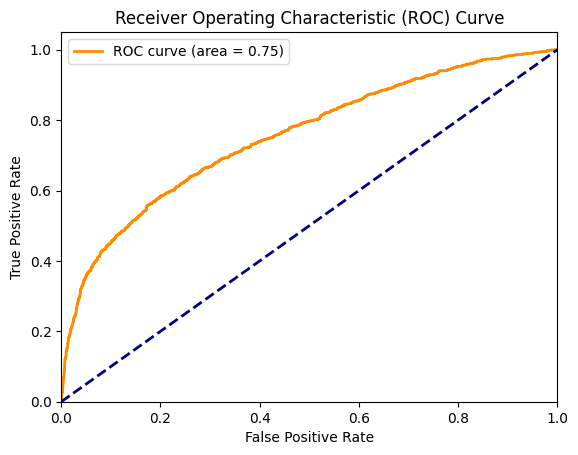

AUC: 0.7538634052085519


In [34]:
# Pretrain TabNet 
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.SGD,
    optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
    mask_type='entmax',
    verbose=10,
)

unsupervised_model.fit(
    X_train=X_train_prepared,
    eval_set=[X_val_prepared],
    max_epochs=100,
    batch_size=1024, virtual_batch_size=128,  # 1024 128
    patience=20,  # 20
)

# Fine tune TabNet
model = TabNetClassifier(
    optimizer_fn=torch.optim.SGD,
    optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"mode": "min", "factor": 0.1, "patience": 5},
    mask_type='entmax',
    verbose=10,
)

model.fit(X_train_prepared, y_train,
        eval_set=[(X_val_prepared, y_val)],
        max_epochs=100,
        batch_size=64, virtual_batch_size=32,
        from_unsupervised=unsupervised_model,
        patience=20,
)

tabnet_importances = model.feature_importances_
print(tabnet_importances)

pred_y = model.predict(X_test_prepared)
pred_probs = model.predict_proba(X_test_prepared)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print("AUC:", roc_auc_score(y_test, pred_probs))

### Step3: Build model pipeline

In [19]:
class TabNetClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer_fn=torch.optim.SGD, optimizer_params=None, scheduler_fn=None, scheduler_params=None, mask_type='entmax', verbose=10):
        if optimizer_params is None:
            optimizer_params = dict(lr=1e-1, momentum=0.938, weight_decay=1e-4)
        if scheduler_params is None:
            scheduler_params = {"mode": "min", "factor": 0.1, "patience": 5}

        self.optimizer_fn = optimizer_fn
        self.optimizer_params = optimizer_params
        self.scheduler_fn = scheduler_fn
        self.scheduler_params = scheduler_params
        self.mask_type = mask_type
        self.verbose = verbose
        self.tabnet_pretrainer = None
        self.tabnet_model = None

    def fit(self, X, y):
        torch.manual_seed(42)

        # TabNet pretrain
        self.tabnet_pretrainer = TabNetPretrainer(
            optimizer_fn=self.optimizer_fn,
            optimizer_params=self.optimizer_params,
            mask_type=self.mask_type,
            verbose=self.verbose
        )
        self.tabnet_pretrainer.fit(X_train=X, eval_set=[X_val_prepared], max_epochs=100, batch_size=1024, virtual_batch_size=128, patience=20)

        # TabNet fine tune
        self.tabnet_model = TabNetClassifier(
            optimizer_fn=self.optimizer_fn,
            optimizer_params=self.optimizer_params,
            scheduler_fn=self.scheduler_fn,
            scheduler_params=self.scheduler_params,
            mask_type=self.mask_type,
            verbose=self.verbose
        )
        self.tabnet_model.fit(
            X_train=X, y_train=y,
            eval_set=[(X_val_prepared, y_val)],
            max_epochs=100,
            batch_size=64,
            virtual_batch_size=32,
            from_unsupervised=self.tabnet_pretrainer,
            patience=20
        )
        return self

    def predict_proba(self, X):
        if self.tabnet_model is not None:
            return self.tabnet_model.predict_proba(X)
        else:
            raise AttributeError("TabNet model is not trained yet. Please call fit before predict_proba.")

    def predict(self, X):
        return self.tabnet_model.predict(X)

    def save_model(self, path):
        """Save TabNet model."""
        if self.tabnet_model is not None:
            self.tabnet_model.save_model(path)
        else:
            raise AttributeError("TabNet model is not trained yet. Please call fit before saving.")

    @staticmethod
    def load_model(path):
        """Load TabNet model."""
        loaded_model = TabNetClassifier()
        loaded_model.load_model(path)
        wrapper = TabNetClassifierWrapper()
        wrapper.tabnet_model = loaded_model
        return wrapper

In [20]:
tabnet_pipeline = make_pipeline(final_pipeline,
                                TabNetClassifier(
                                optimizer_fn=torch.optim.SGD,
                                optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
                                scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                                scheduler_params={"mode": "min", "factor": 0.1, "patience": 5},
                                mask_type='entmax',
                                verbose=10,
                            ))
tabnet_pipeline

/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('logtransformer',
                                                                   LogTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'AGE',...
                ('tabnetclassifier',
                 TabNetClassifier(cat_dims=[], cat_emb_dim=[], cat_idxs=[], grouped_features=[], mask_type='entmax', optimizer_fn=<class 'torch.optim.sgd.SGD'>, optimizer_params={'lr': 0.1, 'momentum': 0.938, 'weight_decay': 0.0001}, scheduler_fn=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_params={'factor': 0.1, 'mode': 'min', 'patience': 5}, verbose=10))])

In [21]:
tabnet_pipeline = make_pipeline(final_pipeline, TabNetClassifierWrapper(
    optimizer_fn=torch.optim.SGD,
    optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"mode": "min", "factor": 0.1, "patience": 5},
    mask_type='entmax',
    verbose=10
))

tabnet_pipeline.fit(X_train, y_train)

pred_prob = tabnet_pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred_prob)

/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.7482  | val_0_unsup_loss_numpy: 1.3894599676132202|  0:00:01s
epoch 10 | loss: 0.9461  | val_0_unsup_loss_numpy: 1.0381200313568115|  0:00:16s
epoch 20 | loss: 0.90702 | val_0_unsup_loss_numpy: 0.8222900032997131|  0:00:32s
epoch 30 | loss: 0.87792 | val_0_unsup_loss_numpy: 0.8073499798774719|  0:00:49s
epoch 40 | loss: 0.85615 | val_0_unsup_loss_numpy: 0.761680006980896|  0:01:05s
epoch 50 | loss: 0.88482 | val_0_unsup_loss_numpy: 0.7554100155830383|  0:01:22s
epoch 60 | loss: 0.87883 | val_0_unsup_loss_numpy: 0.7271199822425842|  0:01:39s
epoch 70 | loss: 0.86057 | val_0_unsup_loss_numpy: 0.7315199971199036|  0:01:54s
epoch 80 | loss: 0.82563 | val_0_unsup_loss_numpy: 0.7176200151443481|  0:02:09s
epoch 90 | loss: 0.84594 | val_0_unsup_loss_numpy: 0.7104399800300598|  0:02:24s

Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_unsup_loss_numpy = 0.6972299814224243


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.46963 | val_0_auc: 0.74193 |  0:00:06s
epoch 10 | loss: 0.43946 | val_0_auc: 0.77133 |  0:01:01s
epoch 20 | loss: 0.43715 | val_0_auc: 0.7726  |  0:01:56s
epoch 30 | loss: 0.43675 | val_0_auc: 0.7726  |  0:02:49s
epoch 40 | loss: 0.43797 | val_0_auc: 0.77249 |  0:03:43s
epoch 50 | loss: 0.4387  | val_0_auc: 0.77199 |  0:04:37s

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_auc = 0.77281


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


0.7568058807905924

In [22]:
# Save model

save_path = 'tabnet_model'

tabnet_wrapper = tabnet_pipeline.named_steps['tabnetclassifierwrapper']
tabnet_wrapper.save_model(save_path)

Successfully saved model at tabnet_model.zip


In [23]:
# Load model

loaded_wrapper = TabNetClassifierWrapper.load_model('tabnet_model.zip')
predict = loaded_wrapper.predict(X_test_prepared)

/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [24]:
# Show predictions' value counts

pd.Series(predict).value_counts()

0    5299
1     701
Name: count, dtype: int64

# Package

In [25]:
from interpretabnet import InterpreTabNet

model = InterpreTabNet()
model.fit()

/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.7482  | val_0_unsup_loss_numpy: 1.3894599676132202|  0:00:01s
epoch 10 | loss: 0.9461  | val_0_unsup_loss_numpy: 1.0381200313568115|  0:00:15s
epoch 20 | loss: 0.90702 | val_0_unsup_loss_numpy: 0.8222900032997131|  0:00:30s
epoch 30 | loss: 0.87792 | val_0_unsup_loss_numpy: 0.8073499798774719|  0:00:44s
epoch 40 | loss: 0.85615 | val_0_unsup_loss_numpy: 0.761680006980896|  0:00:58s
epoch 50 | loss: 0.88482 | val_0_unsup_loss_numpy: 0.7554100155830383|  0:01:12s
epoch 60 | loss: 0.87883 | val_0_unsup_loss_numpy: 0.7271199822425842|  0:01:26s
epoch 70 | loss: 0.86057 | val_0_unsup_loss_numpy: 0.7315199971199036|  0:01:40s
epoch 80 | loss: 0.82563 | val_0_unsup_loss_numpy: 0.7176200151443481|  0:01:55s
epoch 90 | loss: 0.84594 | val_0_unsup_loss_numpy: 0.7104399800300598|  0:02:09s

Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_unsup_loss_numpy = 0.6972299814224243


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:95: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.46963 | val_0_auc: 0.74193 |  0:00:05s
epoch 10 | loss: 0.43946 | val_0_auc: 0.77133 |  0:00:59s
epoch 20 | loss: 0.43715 | val_0_auc: 0.7726  |  0:01:53s
epoch 30 | loss: 0.43675 | val_0_auc: 0.7726  |  0:02:46s
epoch 40 | loss: 0.43797 | val_0_auc: 0.77249 |  0:03:39s
epoch 50 | loss: 0.4387  | val_0_auc: 0.77199 |  0:04:32s

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_auc = 0.77281


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [44]:
model.get_Xs()

(       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
 8049      240000    1          2         1   39     -1     -1     -1     -1   
 29714      20000    1          2         2   36      0      0      0      0   
 21784     320000    2          3         2   25      0      0      0      0   
 26932     130000    1          2         1   44      0      0      0     -1   
 21516      60000    2          2         2   26      2      2      2      2   
 ...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
 22847     310000    2          1         2   36      0      0      0      0   
 25516     240000    2          2         2   25     -2     -2     -2     -2   
 2145      170000    1          4         1   28      0      0      0     -1   
 15305     100000    2          2         1   33      0      0      0      0   
 25509      60000    2          1         2   25      0      0      0      0   
 
        PAY_5  ...  BILL_AMT3  BILL_AM

In [45]:
model.get_ys()

(8049     0
 29714    0
 21784    0
 26932    1
 21516    0
         ..
 22847    0
 25516    0
 2145     0
 15305    0
 25509    0
 Name: default payment next month, Length: 21000, dtype: int64,
 24460    0
 12858    0
 21785    0
 22192    1
 4485     0
         ..
 9704     0
 25487    0
 7377     0
 25432    0
 16076    0
 Name: default payment next month, Length: 3000, dtype: int64,
 6907     0
 24575    0
 26766    0
 2156     1
 3179     0
         ..
 8836     0
 1259     0
 27309    0
 29583    0
 24399    0
 Name: default payment next month, Length: 6000, dtype: int64)

In [39]:
interpretabnet_pipeline = model.get_model()
interpretabnet_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('logtransformer',
                                                                   LogTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'AGE',...
       [-0.15977739,  0.80504219,  0.18494347, ..., -0.2966546 ,
        -0.2927254 , -0.26224844]]),
                                         optimizer_params={'lr': 0.1,
                                                           'momentum': 0.938,
                                                           'weight_decay': 0.0001},
                                         scheduler_fn=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>,
                                         scheduler_params={'factor': 0.1,
                                                           'mode': 'min',
                                                           'patience': 5},
                                         y_val=24460    0
12858    0
21785    0
22192    1
4485     0
        ..
9704     0
25487    0
7377     0
25432    0
16076    0
Name: default payment next month, Length: 3000, dtype: int64))])

In [40]:
pred_prob = interpretabnet_pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred_prob)

0.7568058807905924

In [41]:
# Show predictions' value counts

predict = interpretabnet_pipeline.predict(X_test)
pd.Series(predict).value_counts()

0    5299
1     701
Name: count, dtype: int64

# InterpreStability

## 1. Train sub-models

In [30]:
num_models = 9
models = {}
importances = {}
arrays = []
variances = []

for k in range(9):
    np.random.seed(k)
    random_indices = np.random.choice(X_train_prepared.shape[0], 10_000, replace=False)

    model_key = f"model_{k}"
    importance_key = f"importance_{k}"

    # Pretrain TabNet 
    unsupervised_model = TabNetPretrainer(
        optimizer_fn=torch.optim.SGD,
        optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
        mask_type='entmax',
        verbose=0,
    )

    unsupervised_model.fit(
        X_train=X_train_prepared[random_indices],
        eval_set=[X_val_prepared],
        max_epochs=100,
        batch_size=1024, virtual_batch_size=128,  # 1024 128
        patience=20,  # 20
    )

    # Fine tune TabNet
    model = TabNetClassifier(
        optimizer_fn=torch.optim.SGD,
        optimizer_params=dict(lr=1e-1, momentum=0.938, weight_decay=1e-4),
        scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
        scheduler_params={"mode": "min", "factor": 0.1, "patience": 5},
        mask_type='entmax',
        verbose=0,
    )

    model.fit(X_train_prepared[random_indices], y_train[random_indices],
            eval_set=[(X_val_prepared, y_val)],
            max_epochs=100,
            batch_size=64, virtual_batch_size=32,
            from_unsupervised=unsupervised_model,
            patience=20,
    )
    
    # Calculate Permutation Feature Importance
    perm_importance = permutation_importance(model, X_train_prepared[random_indices], y_train[random_indices],
                                             n_repeats=30, random_state=42, scoring='accuracy')
    variances.append(np.var(perm_importance.importances_mean))

    # Get feature importances
    models[model_key] = model
    importances[importance_key] = model.feature_importances_
    arrays.append(importances[importance_key])


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_unsup_loss_numpy = 0.7289100289344788


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_auc = 0.75958


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_unsup_loss_numpy = 0.7238199710845947


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_auc = 0.76355


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_unsup_loss_numpy = 0.8111699819564819


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_auc = 0.75837


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_0_unsup_loss_numpy = 0.7666400074958801


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_auc = 0.75643


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_unsup_loss_numpy = 0.8063600063323975


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_auc = 0.77006


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_unsup_loss_numpy = 0.7213299870491028


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_auc = 0.76326


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_unsup_loss_numpy = 0.7910199761390686


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_auc = 0.75187


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_val_0_unsup_loss_numpy = 0.7560700178146362


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_auc = 0.75964


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_val_0_unsup_loss_numpy = 0.8227099776268005


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/abstract_model.py:261: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")



Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_auc = 0.75165


/Users/shiyunwa/Documents/InterpreTabNet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 2. Calculate correlation matrix

In [31]:
correlation_matrix = np.zeros((len(arrays), len(arrays)))

for i in range(len(arrays)):
    for j in range(len(arrays)):
        correlation_matrix[i, j] = np.corrcoef(arrays[i], arrays[j])[0, 1]

correlation_matrix = abs(correlation_matrix)

print('Correlation matrix:')
print(correlation_matrix)

upper_tri = correlation_matrix[np.triu_indices(len(correlation_matrix), k=1)]
proba = []

count_09_1 = np.sum((upper_tri >= 0.9) & (upper_tri <= 1))
count_07_09 = np.sum((upper_tri >= 0.7) & (upper_tri < 0.9))
count_05_07 = np.sum((upper_tri >= 0.5) & (upper_tri < 0.7))
count_03_05 = np.sum((upper_tri >= 0.3) & (upper_tri < 0.5))
count_0_03 = np.sum((upper_tri >= 0) & (upper_tri < 0.3))
count_odd = np.sum((upper_tri < 0) | (upper_tri > 1))

# total_elements = 45
total_elements = (len(correlation_matrix) * len(correlation_matrix) - len(correlation_matrix)) / 2
percentage_09_1 = count_09_1 / total_elements
proba.append(percentage_09_1)
percentage_07_09 = count_07_09 / total_elements
proba.append(percentage_07_09)
percentage_05_07 = count_05_07 / total_elements
proba.append(percentage_05_07)
percentage_03_05 = count_03_05 / total_elements
proba.append(percentage_03_05)
percentage_0_03 = count_0_03 / total_elements
proba.append(percentage_0_03)
percentage_odd = count_odd / total_elements
proba.append(percentage_odd)

print("Percentage [0.9, 1]:", percentage_09_1)  # very high correlation
print("Percentage [0.7, 0.9]:", percentage_07_09)  # high correlation
print("Percentage [0.5, 0.7]:", percentage_05_07)  # moderate correlation
print("Percentage [0.3, 0.5]:", percentage_03_05)  # low correlation
print("Percentage [0, 0.3]:", percentage_0_03)  # little if any correlation
print("Percentage (-, 0) & (1, +):", percentage_odd)

weights = [1.0, 0.8, 0.6, 0.4, 0.2, 0]  # focus more on high correlation strength part
score = sum(p*w for p, w in zip(proba, weights))

interprestability = score / max(weights)
print(interprestability)

for i, variance in enumerate(variances):
    print(f"Subset {i + 1} Variance: {variance}")

print(np.mean(variances))

Correlation matrix:
[[1.         0.64895458 0.76807224 0.01448131 0.59137493 0.15709574
  0.80409409 0.80452556 0.89015924]
 [0.64895458 1.         0.8654477  0.42400826 0.72417117 0.34414125
  0.53879755 0.49361614 0.50423608]
 [0.76807224 0.8654477  1.         0.15493327 0.79211085 0.14338714
  0.79358359 0.79157274 0.72839548]
 [0.01448131 0.42400826 0.15493327 1.         0.03549519 0.85924109
  0.09345386 0.36993826 0.18912089]
 [0.59137493 0.72417117 0.79211085 0.03549519 1.         0.0804532
  0.58153763 0.70061549 0.48344793]
 [0.15709574 0.34414125 0.14338714 0.85924109 0.0804532  1.
  0.10030853 0.16191733 0.04089165]
 [0.80409409 0.53879755 0.79358359 0.09345386 0.58153763 0.10030853
  1.         0.75115443 0.82594313]
 [0.80452556 0.49361614 0.79157274 0.36993826 0.70061549 0.16191733
  0.75115443 1.         0.8689294 ]
 [0.89015924 0.50423608 0.72839548 0.18912089 0.48344793 0.04089165
  0.82594313 0.8689294  1.        ]]
Percentage [0.9, 1]: 0.0
Percentage [0.7, 0.9]: 0.41

## 3. Visualization

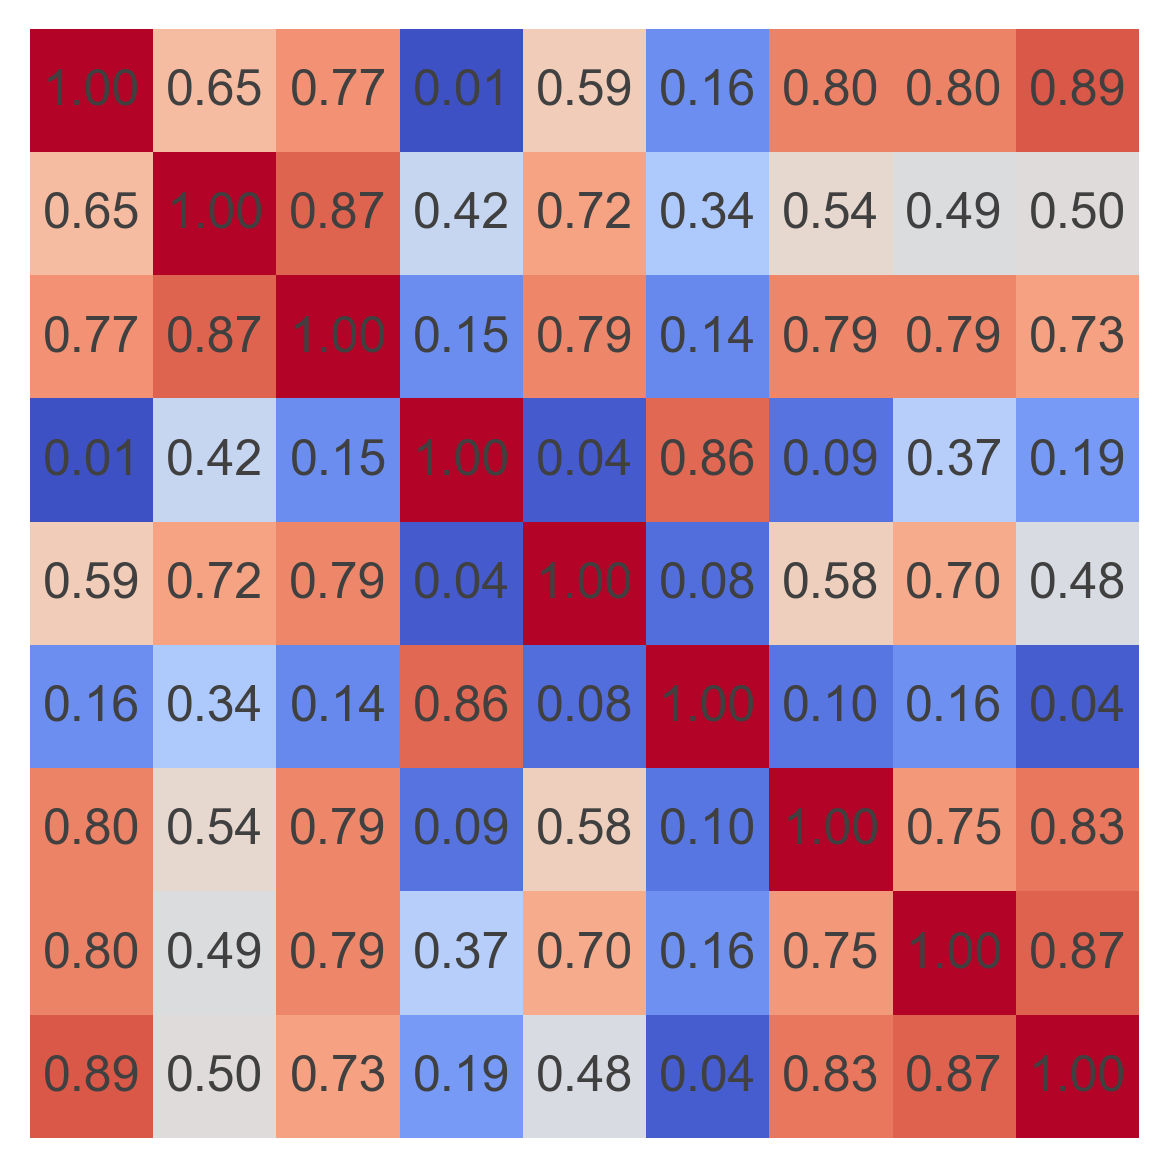

In [32]:
fig, ax = plt.subplots(dpi=300)
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=0, vmax=1)

arial_font = FontProperties(family='Arial', style='normal', size=12)

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, "{:.2f}".format(correlation_matrix[i, j]),
                 ha="center", va="center", color="#404040", fontproperties=arial_font)

ax.axis('off')
plt.show()
# plt.savefig('fig/TabNet10000.png', bbox_inches='tight')